<a href="https://colab.research.google.com/github/raflinoob132/MachineLearning-1/blob/main/UTS/Regression%20Task/UTS_Regression_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')
import math

# Download dataset
import gdown
file_id = "1oEXSD137hPm_Fx5xSPRvlAr3silj3suK"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="RegresiUTSTelkom.csv", quiet=False)

# Load dataset
df = pd.read_csv("RegresiUTSTelkom.csv")
print("Data loaded successfully!")
print(f"Data shape: {df.shape}")


Downloading...
From (original): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK
From (redirected): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK&confirm=t&uuid=dc0bfaa1-19b8-4d15-8c16-6f5240147d6c
To: /content/RegresiUTSTelkom.csv
100%|██████████| 443M/443M [00:06<00:00, 65.1MB/s]


Data loaded successfully!
Data shape: (515344, 91)


In [3]:

# Rename columns untuk memudahkan
first_column = df.columns[0]
df = df.rename(columns={first_column: 'Target'})
new_columns = ['target'] + [f'x{i}' for i in range(1, len(df.columns))]
df.columns = new_columns

# Tampilkan informasi awal
print("\nMelihat 5 data pertama:")
print(df.head())
print("\nInformasi data:")
print(df.info())
print("\nDeskripsi statistik:")
print(df.describe())



Melihat 5 data pertama:
   target        x1        x2        x3        x4        x5        x6  \
0    2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   
1    2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940   
2    2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   
3    2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409   
4    2001  50.54767   0.31568  92.35066  22.38696 -25.51870 -19.04928   

         x7        x8        x9  ...       x81        x82       x83       x84  \
0   8.76630  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836   
1  -3.27872  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792   
2   5.05097 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617   
3 -12.48207  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522   
4  20.67345  -5.19943   3.63566  ...   6.59753  -50.69577  26.02574  18.94430   

        x85       x86        x87       x88       

In [4]:

# TAHAP 1: PEMBERSIHAN DATA

print("\n--- PEMBERSIHAN DATA ---")

# Cek missing values
missing_values = df.isnull().sum()
print("\nCek missing values:")
print(missing_values[missing_values > 0] if missing_values.any() > 0 else "Tidak ada missing values")

# Cek data duplicates
duplicates = df.duplicated().sum()
print(f"\nJumlah data duplikat: {duplicates}")
if duplicates > 0:
    print("Menghapus data duplikat...")
    df = df.drop_duplicates()
    print(f"Ukuran data setelah menghapus duplikat: {df.shape}")



--- PEMBERSIHAN DATA ---

Cek missing values:
Tidak ada missing values

Jumlah data duplikat: 214
Menghapus data duplikat...
Ukuran data setelah menghapus duplikat: (515130, 91)


In [5]:

# TAHAP 2: FEATURE SELECTION

print("\n--- FEATURE SELECTION ---")

# 1. Menghapus feature dengan korelasi tinggi terhadap feature lain
# Berdasarkan hasil analisis korelasi yang diberikan
high_corr_features = ['x18', 'x20', 'x22', 'x23', 'x60']  # Sample of features with high correlation
print(f"\nMenghapus fitur dengan korelasi tinggi: {high_corr_features}")
df_filtered = df.drop(columns=high_corr_features)
print(f"Jumlah fitur setelah menghapus fitur dengan korelasi tinggi: {len(df_filtered.columns)-1}")

# 2. Korelasi dengan target
target_correlation = df_filtered.corr()['target'].sort_values(ascending=False)
print("\nKorelasi fitur dengan target (top 10):")
print(target_correlation[1:11])  # Exclude target itself

# Visualisasi korelasi target dengan 10 fitur teratas
plt.figure(figsize=(12, 6))
target_correlation[1:11].plot(kind='bar')
plt.title('Korelasi 10 Fitur Teratas dengan Target')
plt.tight_layout()
plt.savefig('target_correlation.png')
plt.close()

# 3. Mutual Information (untuk menangkap hubungan non-linear)
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

# Bagi data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hitung Mutual Information
mi_selector = SelectKBest(mutual_info_regression, k=30)  # Pilih 30 fitur terbaik
X_train_selected = mi_selector.fit_transform(X_train, y_train)
X_test_selected = mi_selector.transform(X_test)

# Dapatkan nama fitur yang dipilih
selected_features_idx = mi_selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features_idx]
print("\nFitur yang dipilih berdasarkan Mutual Information:")
print(selected_feature_names.tolist())

# Visualisasi MI scores
mi_scores = pd.DataFrame(
    {'Feature': X.columns,
     'MI Score': mi_selector.scores_}
)
mi_scores = mi_scores.sort_values('MI Score', ascending=False)
plt.figure(figsize=(12, 6))
mi_scores.head(15).plot(x='Feature', y='MI Score', kind='bar')
plt.title('Top 15 Fitur berdasarkan Mutual Information')
plt.tight_layout()
plt.savefig('mutual_information.png')
plt.close()

# Gunakan DataFrame untuk fitur yang dipilih
X_train_selected_df = X_train[selected_feature_names]
X_test_selected_df = X_test[selected_feature_names]



--- FEATURE SELECTION ---

Menghapus fitur dengan korelasi tinggi: ['x18', 'x20', 'x22', 'x23', 'x60']
Jumlah fitur setelah menghapus fitur dengan korelasi tinggi: 85

Korelasi fitur dengan target (top 10):
x1     0.225345
x7     0.110461
x47    0.096069
x73    0.083760
x74    0.081745
x68    0.081382
x14    0.078722
x38    0.074450
x53    0.074042
x29    0.073345
Name: target, dtype: float64

Fitur yang dipilih berdasarkan Mutual Information:
['x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x14', 'x16', 'x24', 'x25', 'x31', 'x33', 'x36', 'x37', 'x39', 'x40', 'x41', 'x46', 'x47', 'x50', 'x57', 'x58', 'x63', 'x67', 'x68', 'x69', 'x73', 'x79', 'x82', 'x86']


<Figure size 1200x600 with 0 Axes>

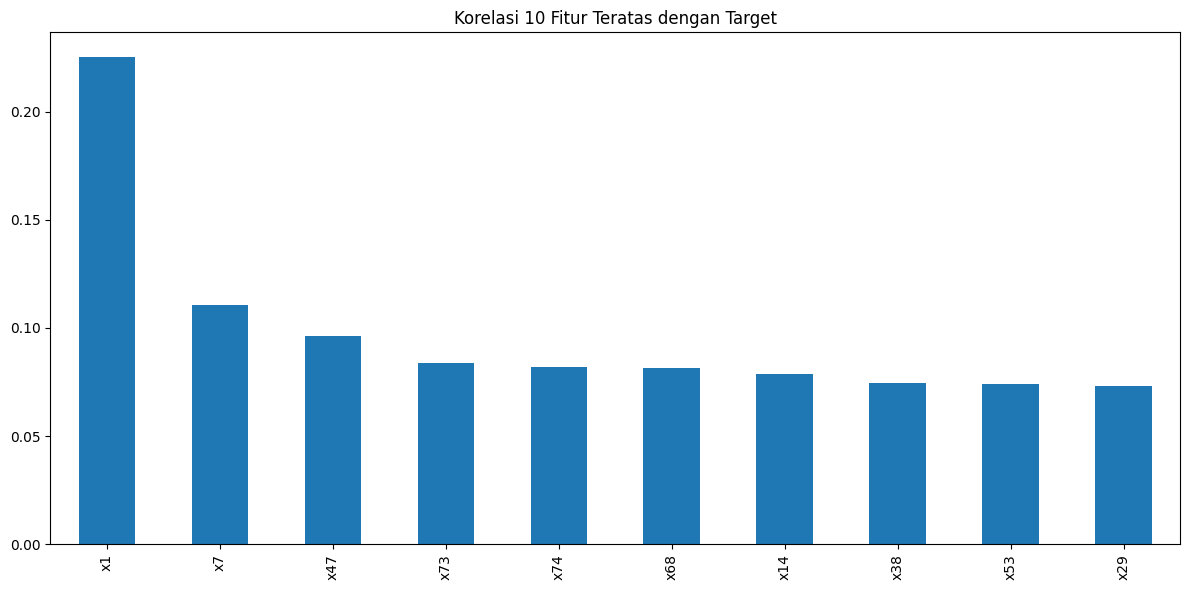

In [12]:
# Visualisasi korelasi target dengan 10 fitur teratas
plt.figure(figsize=(12, 6))
target_correlation[1:11].plot(kind='bar')
plt.title('Korelasi 10 Fitur Teratas dengan Target')
plt.tight_layout()
plt.show()  # <- tampil langsung di Colab


<Figure size 1200x600 with 0 Axes>

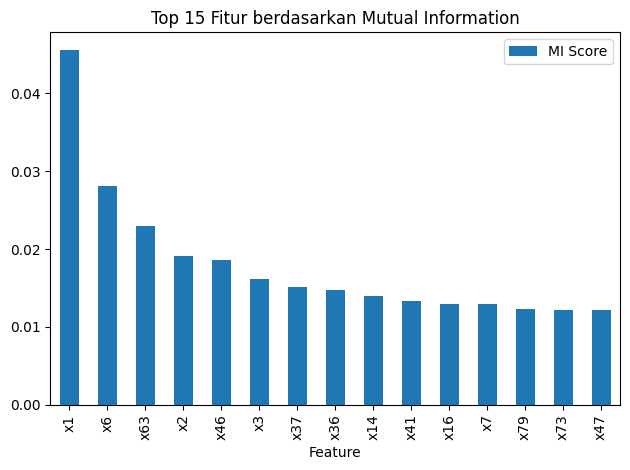

In [13]:
# Visualisasi MI scores
mi_scores = pd.DataFrame(
    {'Feature': X.columns,
     'MI Score': mi_selector.scores_}
)
mi_scores = mi_scores.sort_values('MI Score', ascending=False)
plt.figure(figsize=(12, 6))
mi_scores.head(15).plot(x='Feature', y='MI Score', kind='bar')
plt.title('Top 15 Fitur berdasarkan Mutual Information')
plt.tight_layout()
plt.show()


In [6]:

# TAHAP 3: FEATURE ENGINEERING

print("\n--- FEATURE ENGINEERING ---")

# 1. Standarisasi fitur numerik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected_df)
X_test_scaled = scaler.transform(X_test_selected_df)

print("Data telah distandarisasi")



--- FEATURE ENGINEERING ---
Data telah distandarisasi


In [7]:

# TAHAP 4: MODEL BUILDING DAN EVALUASI

print("\n--- MODEL BUILDING & EVALUASI ---")

# Daftar model yang akan diuji
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (degree=2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linear', LinearRegression())
    ]),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Bagging Regressor': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    #'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    #'SVR': SVR(kernel='rbf')
}



--- MODEL BUILDING & EVALUASI ---


In [8]:

# Evaluasi metric
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Fit model
    model.fit(X_train_scaled, y_train)

    # Prediksi
    y_pred = model.predict(X_test_scaled)

    # Hitung metric
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Simpan hasil
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    })



Training Linear Regression...

Training Polynomial Regression (degree=2)...

Training Decision Tree...

Training KNN...

Training Bagging Regressor...

Training AdaBoost...


In [10]:

# Buat tabel perbandingan
results_df = pd.DataFrame(results)
print("\nPerbandingan Model:")
print(results_df.set_index('Model'))

# Cari model terbaik berdasarkan RMSE
best_model_rmse = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nModel terbaik berdasarkan RMSE: {best_model_rmse['Model']} dengan RMSE = {best_model_rmse['RMSE']:.4f}")

# Cari model terbaik berdasarkan R-squared
best_model_r2 = results_df.loc[results_df['R-squared'].idxmax()]
print(f"Model terbaik berdasarkan R-squared: {best_model_r2['Model']} dengan R-squared = {best_model_r2['R-squared']:.4f}")

# Visualisasi perbandingan model
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot RMSE
sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[0])
axes[0].set_title('RMSE per Model (Lower is Better)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot R-squared
sns.barplot(x='Model', y='R-squared', data=results_df, ax=axes[1])
axes[1].set_title('R-squared per Model (Higher is Better)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()



Perbandingan Model:
                                         MSE       RMSE        MAE  R-squared
Model                                                                        
Linear Regression                  94.854905   9.739348   6.946788   0.200932
Polynomial Regression (degree=2)   88.086897   9.385462   6.646844   0.257947
Decision Tree                     178.012405  13.342129   9.031177  -0.499595
KNN                                93.351937   9.661881   6.870860   0.213593
Bagging Regressor                  92.874626   9.637148   6.846353   0.217614
AdaBoost                          144.620976  12.025846  10.293282  -0.218302

Model terbaik berdasarkan RMSE: Polynomial Regression (degree=2) dengan RMSE = 9.3855
Model terbaik berdasarkan R-squared: Polynomial Regression (degree=2) dengan R-squared = 0.2579


Visualizing Linear Regression...


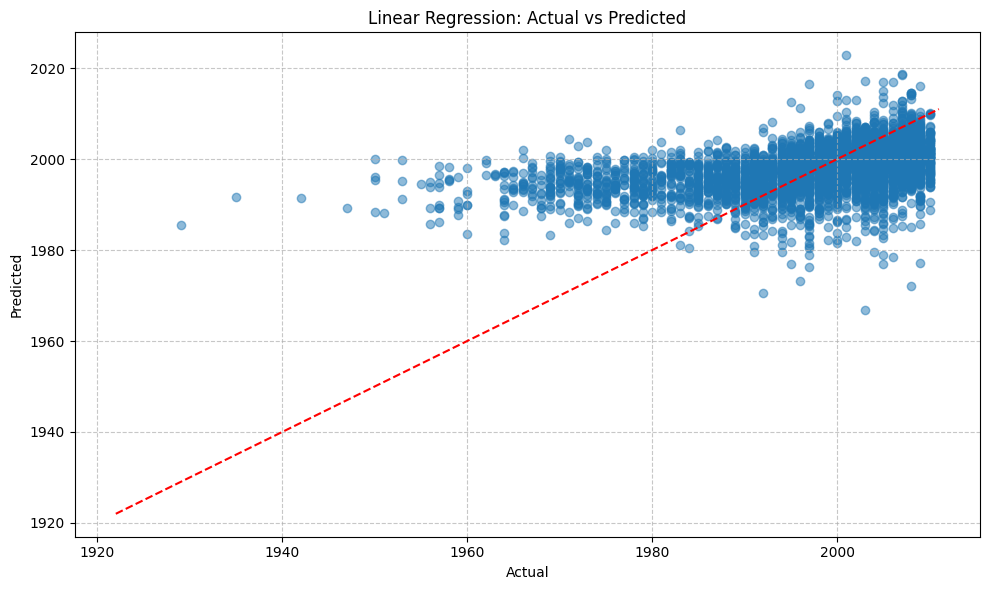

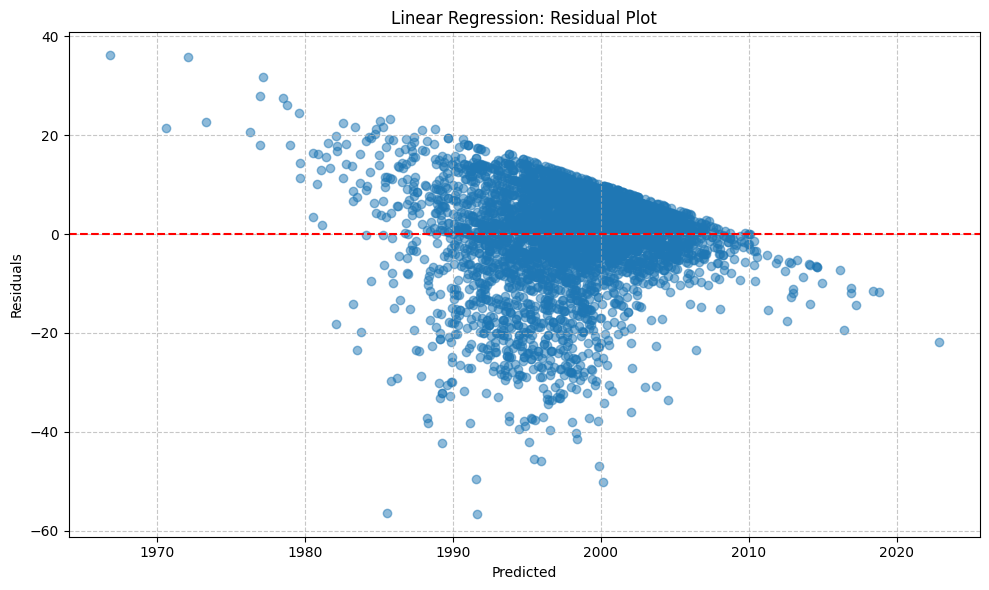

Visualizing Polynomial Regression (degree=2)...


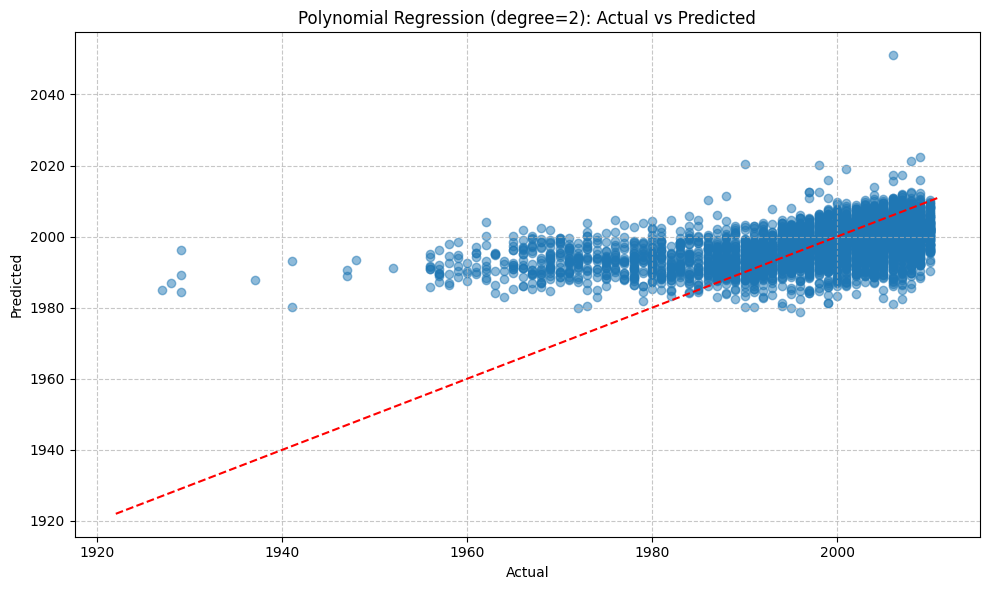

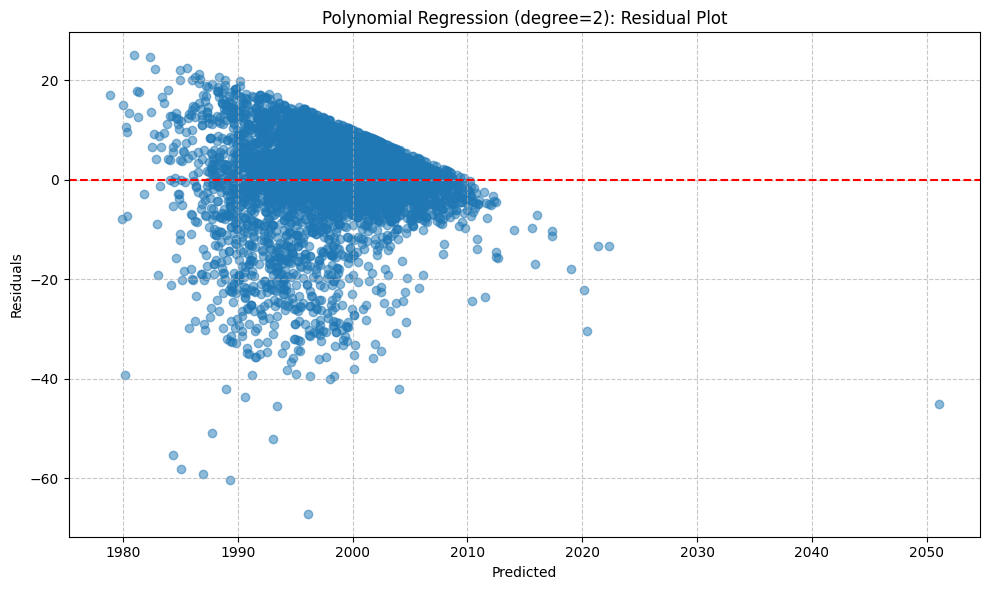

Visualizing Decision Tree...


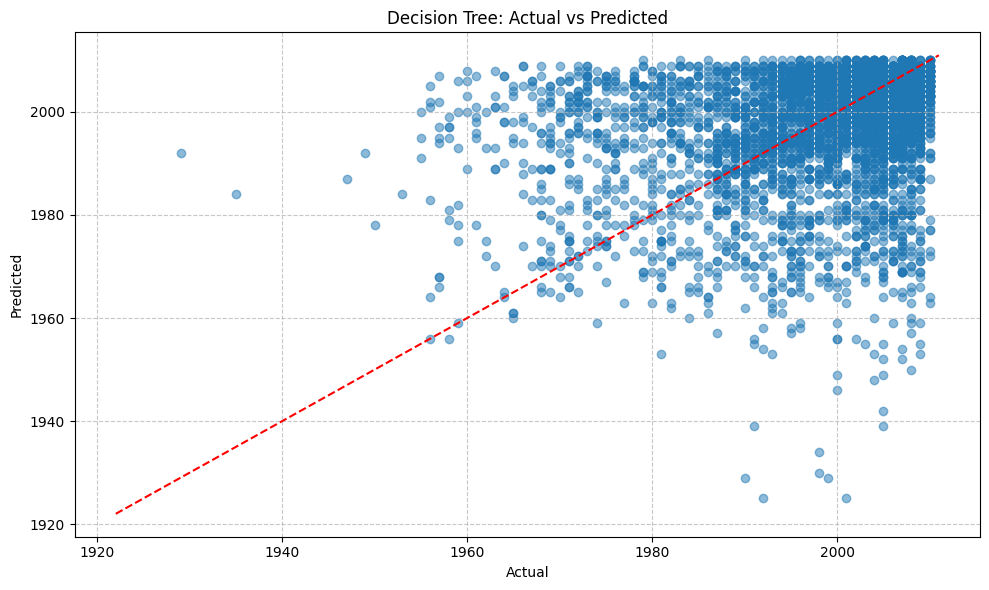

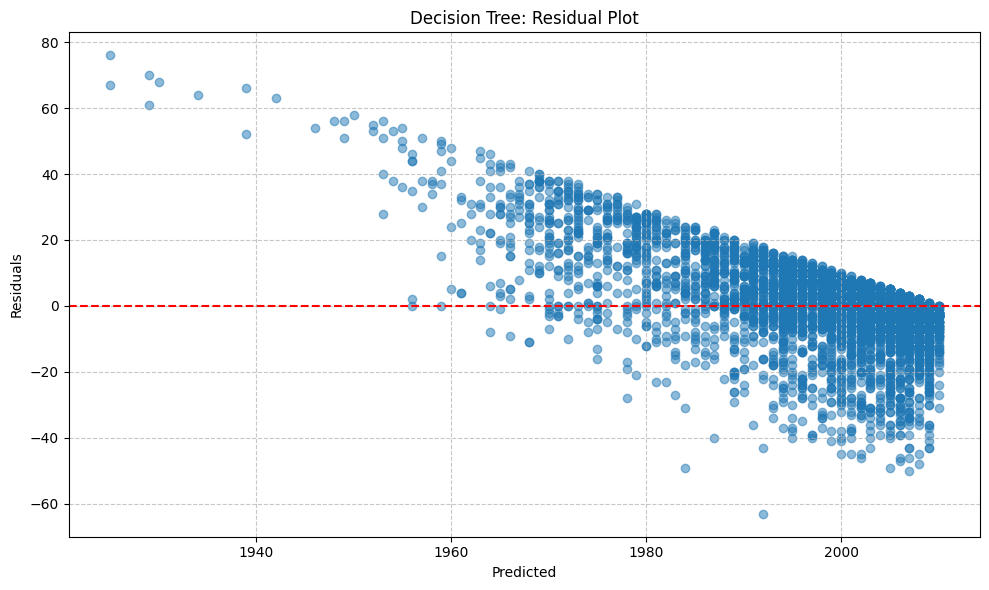

Visualizing KNN...


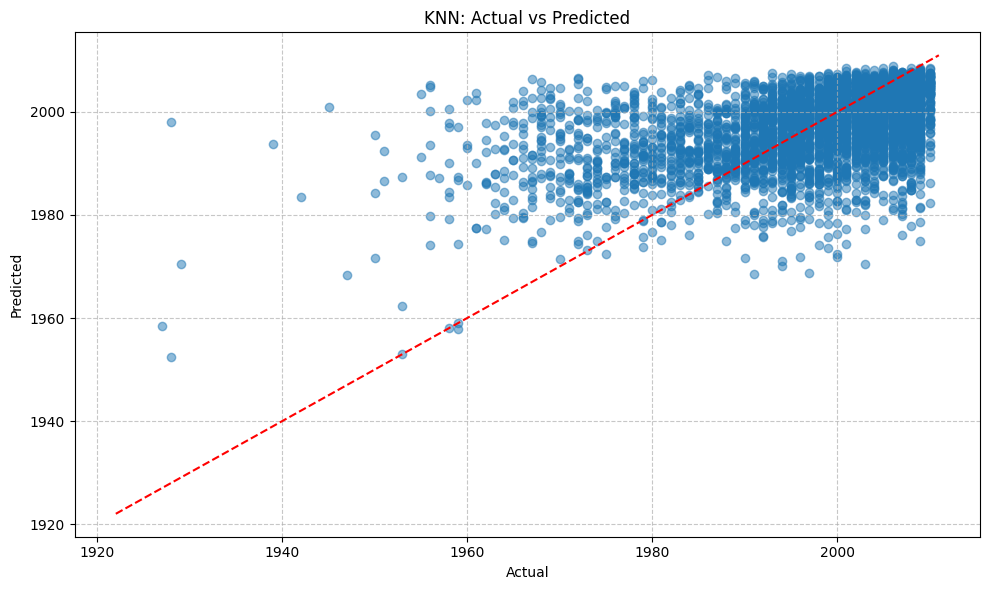

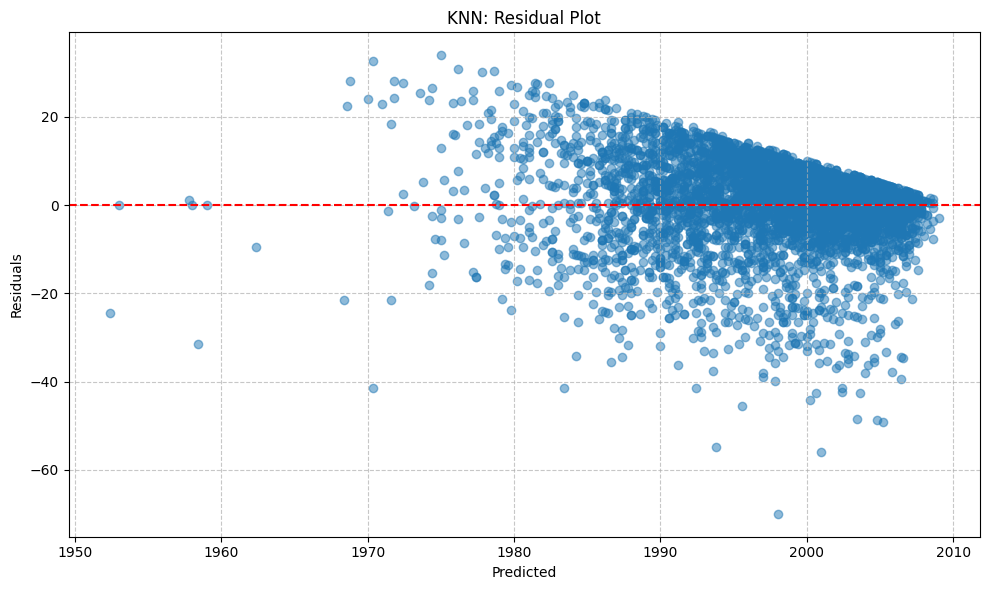

Visualizing Bagging Regressor...


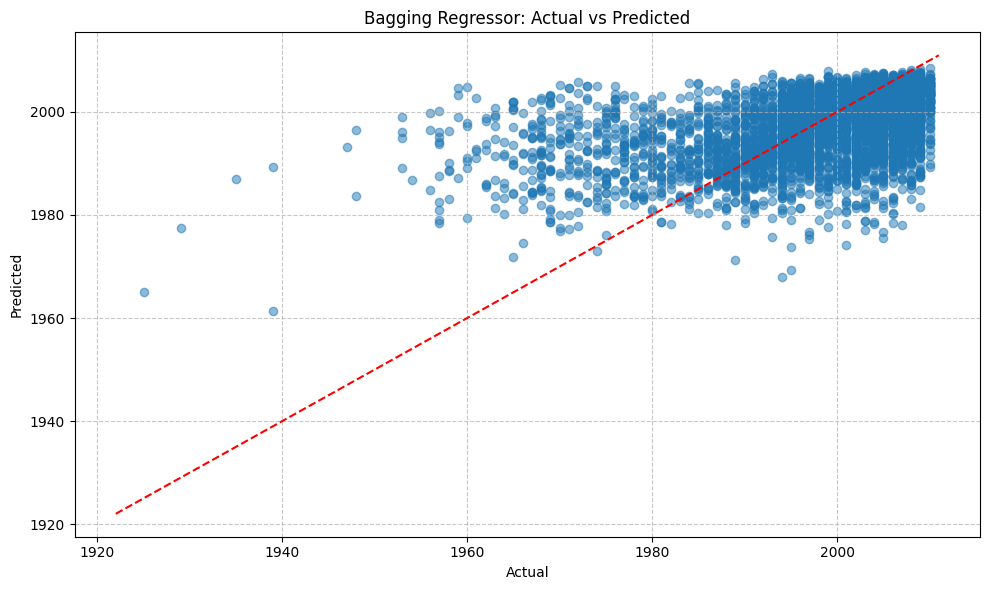

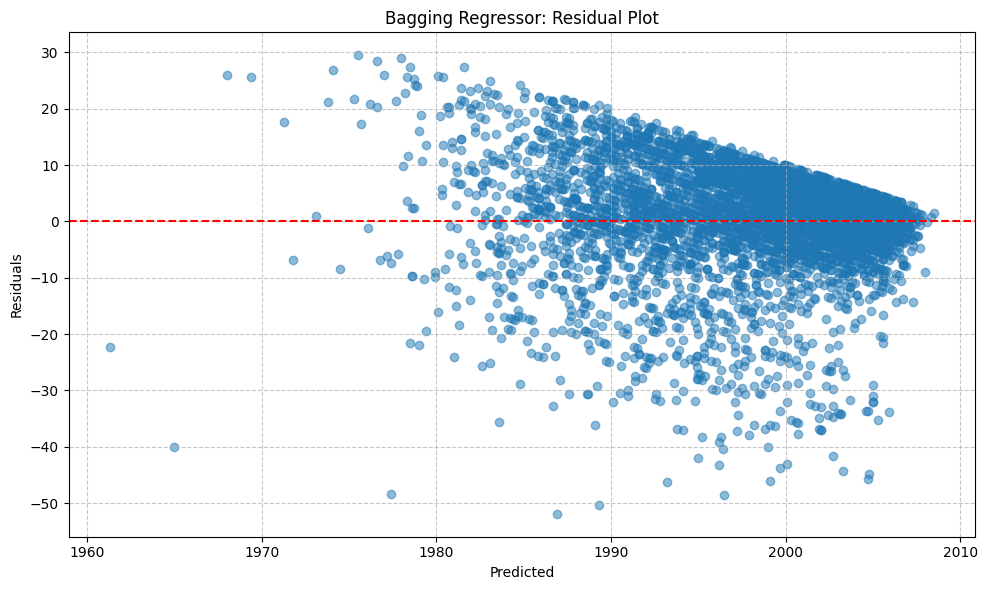

Visualizing AdaBoost...


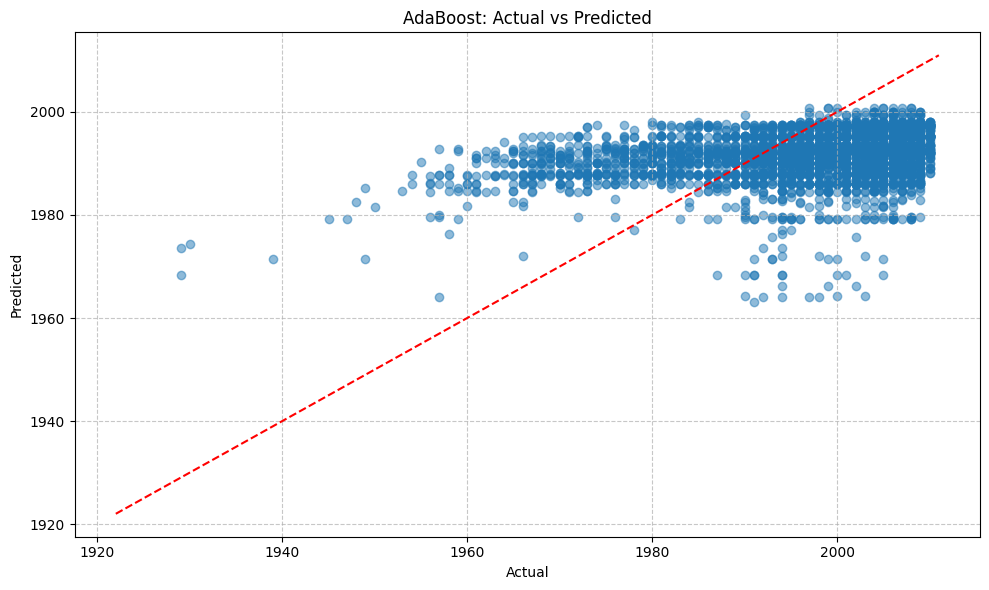

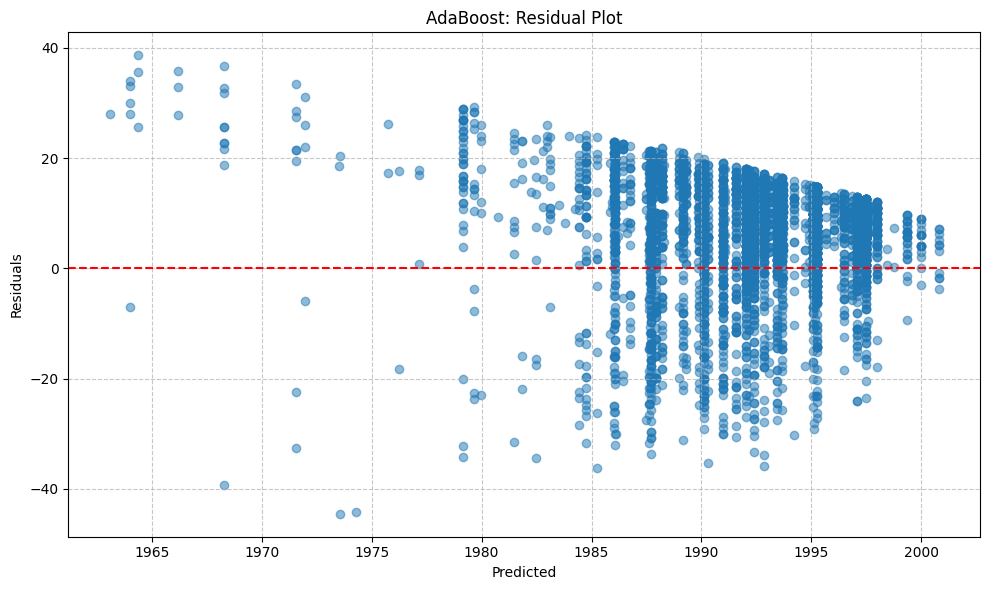

In [18]:
# Loop buat visualisasi tanpa training ulang
for name, model in models.items():
    print(f"Visualizing {name}...")

    # Prediksi lagi (TIDAK fit ulang)
    y_pred = model.predict(X_test_scaled)

    # Visualisasi Actual vs Predicted
    plt.figure(figsize=(10, 6))
    sample_size = min(5000, len(y_test))
    indices = np.random.choice(len(y_test), sample_size, replace=False)
    plt.scatter(y_test.iloc[indices], y_pred[indices], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name}: Actual vs Predicted')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # # Visualisasi Residuals
    # plt.figure(figsize=(10, 6))
    # residuals = y_test - y_pred
    # plt.scatter(y_pred[indices], residuals.iloc[indices], alpha=0.5)
    # plt.axhline(y=0, color='r', linestyle='--')
    # plt.xlabel('Predicted')
    # plt.ylabel('Residuals')
    # plt.title(f'{name}: Residual Plot')
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.show()
